In [1]:
# If additional packages need to be used, uncomment the last two lines of this cell and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies satisfied and works everywhere.

#import sys
#!{sys.executable} -m pip install <package list>

### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings

pd.set_option('display.float_format', lambda num:'%1.3f'%num)
pd.set_option('display.max_columns', 99)
filterwarnings('ignore')

# Data Description

Feature | Description
:---|:---
UniqueId |The unique id of an invoice.
Region |The geographical region of the customer.
OrderDate| The date on which order was placed. (YYYY-MM-DD)
InvoiceDate| The date on which the invoice was generated. (YYYY-MM-DD)
Amount| The amount of the invoice. (in US $)
DueDate| Due date by which payment should have been received. (YYY-MM-DD)
Dispute| Whether the customer has accepted or not the invoice amount. True indicates the invoice is disputed and False indicates the invoice is agreed to.
InvoiceType| The invoice can be of two types, ‘electronic’ or ‘paper’.
Delay|This is the response variable. True to indicate that the payment deadline was violated and False to indicate on-time clearance.


# Data Wrangling & Visualization 




In [3]:
train = pd.read_csv("train.csv", index_col=0)

In [10]:
train.head()
train.shape

(1850, 8)

In [5]:
#Explore columns
train.columns

Index(['Region', 'OrderDate', 'InvoiceDate', 'DueDate', 'Amount', 'Disputed',
       'InvoiceType', 'Delay'],
      dtype='object')

In [6]:
#Description
train.describe()

,Amount
count,1842.000
mean,59.585
std,21.383
min,-97.330
25%,46.320
50%,60.350
75%,73.745
max,128.280


In [953]:
# Pre processing section: remove the null values
train=train.dropna()
null_vals = train.isnull().sum().to_frame(name = 'NULL_COUNTS')
null_vals = null_vals[null_vals['NULL_COUNTS']>0]
null_features = null_vals.index
null_vals

,NULL_COUNTS


In [8]:
#Defining the season for north hemisphere

def find_season(month):
    if month <=3:
        return 1
    elif month >3 and month <=6:
        return 2
    elif month >7 and month <=9:
        return 3
    else:
        return 4

In [954]:
# find the day, week, month, season, and year for Duedate, but day, week, and season, and month for the rest and finally the differnce between DueDate and the rest of date

from datetime import datetime
import datetime


OrderDate=np.c_[train['OrderDate']]
InvoiceDate=np.c_[train['InvoiceDate']]
DueDate=np.c_[train['DueDate']]

# generate InvoiceDate data

invoiceD= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceM= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceW= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceS= np.empty([len(InvoiceDate), 1],dtype=np.int32)


for i in range (0, len(InvoiceDate)):
    dd=InvoiceDate[i,0]
    my_list = dd.split('-')
    invoiceD[i,0]=int(my_list[2])
    invoiceM[i,0]=int(my_list[1])
    invoiceW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    invoiceS[i,0]=find_season(int(my_list[1]))

# generate OrderDate data

orderDateD= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateM= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateW= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateS= np.empty([len(OrderDate), 1],dtype=np.int32)

for i in range (0, len(OrderDate)):
    dd=OrderDate[i,0]
    my_list = dd.split('-')
    orderDateD[i,0]=int(my_list[2])
    orderDateM[i,0]=int(my_list[1])
    orderDateW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    orderDateS[i,0]=find_season(int(my_list[1]))


# generate DueDate data

dueDateD= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateM= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateY= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateW= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateS= np.empty([len(DueDate), 1],dtype=np.int32)

for i in range (0, len(DueDate)):
    dd=DueDate[i,0]
    my_list = dd.split('-')
    dueDateD[i,0]=int(my_list[2])
    dueDateM[i,0]=int(my_list[1])
    dueDateY[i,0]=int(my_list[0])
    dueDateW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    dueDateS[i,0]=find_season(int(my_list[1]))


# generate the difference between two dates

due_invoice= np.empty([len(InvoiceDate), 1],dtype=np.int32)
due_order= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoice_order= np.empty([len(InvoiceDate), 1],dtype=np.int32)

for i in range (0, len(DueDate)):

    s=DueDate[i,0]
    ss=OrderDate[i,0]
    sss=InvoiceDate[i,0]


    from datetime import datetime
    dt = datetime.strptime(s, '%Y-%m-%d').date() 
    dto = datetime.strptime(ss, '%Y-%m-%d').date()
    dtoo = datetime.strptime(sss, '%Y-%m-%d').date()
    h1=dt-dtoo   # difference between DueDate and OrderDate
    h2=dt-dto    # difference between DueDate and OrderDate
    h3=dtoo-dto  # difference between InvoiceDate and OrderDate
    due_invoice[i,0]=int(h1.days)
    due_order[i,0]=int(h2.days)
    invoice_order[i,0]=int(h3.days)

In [955]:
# Calculate various statistical features and parameters of day, month, week, and season of for each client 

from numpy import var
from numpy import std
from numpy import cov
from statistics import median
from statistics import mean
from scipy.stats import gmean
from statsmodels.tsa.ar_model import AutoReg

DATA1=np.array([])
DATA2=np.array([])
DATA3=np.array([])
DATA4=np.array([])
DATA5=np.array([])
DATA6=np.array([])
DATA7=np.array([])
DATA8=np.array([])
DATA9=np.array([])
DATA10=np.array([])
DATA11=np.array([])
DATA12=np.array([])
DATA13=np.array([])
DATA14=np.array([])
DATA15=np.array([])
DATA16=np.array([])
DATA17=np.array([])
DATA18=np.array([])
DATA19=np.array([])
DATA20=np.array([])
DATA21=np.array([])
DATA22=np.array([])
DATA23=np.array([])
DATA24=np.array([])


for i in range (0,len(InvoiceDate)):
    DATA1=np.append(DATA1,median([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA2=np.append(DATA2,mean([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA3=np.append(DATA3,gmean([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA4=np.append(DATA4,var([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA5=np.append(DATA5,std([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA6=np.append(DATA6,cov([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    model=AutoReg([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]],lags=1)
    model_fit = model.fit()
    DATA7=np.append(DATA7,model_fit.params[0])
    DATA8=np.append(DATA8,model_fit.params[1])

    DATA9=np.append(DATA9,median([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA10=np.append(DATA10,mean([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA11=np.append(DATA11,gmean([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA12=np.append(DATA12,var([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA13=np.append(DATA13,std([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA14=np.append(DATA14,cov([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    model=AutoReg([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]],lags=1)
    model_fit = model.fit()
    DATA15=np.append(DATA15,model_fit.params[0])
    DATA16=np.append(DATA16,model_fit.params[1])

    DATA17=np.append(DATA17,median([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA18=np.append(DATA18,mean([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA19=np.append(DATA19,gmean([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA20=np.append(DATA20,var([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA21=np.append(DATA21,std([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA22=np.append(DATA22,cov([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    model=AutoReg([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]],lags=1)
    model_fit = model.fit()
    DATA23=np.append(DATA23,model_fit.params[0])
    DATA24=np.append(DATA24,model_fit.params[1])


In [963]:
# First drop all date related data and the UniqueId from train set and then concatinate the processed data to the rest of train set


train_N=train.drop(columns=['OrderDate','InvoiceDate','DueDate'])  # drop all date related data and the UniqueId from train set 
train_N['Region'].replace(['North America', 'South  America',  'Europe', 'Africa&Asia','South America','Central America','Africa&psia','SouthCUmeVica'], [0, 1, 2, 3,4,5,6,7], inplace=True)  #create dummy variables for region 
train_N=pd.get_dummies(train_N, columns=['Disputed','InvoiceType', 'Delay'], drop_first=True)  # generate dummies for the rest of categorical variables

Y_train=np.c_[train_N['Delay_True']]   # create the target for training and convert it to numpy array

X_train2=np.column_stack((orderDateD,orderDateM,orderDateW,orderDateS,invoiceD,invoiceM,invoiceW,invoiceS,dueDateD,dueDateM,dueDateW,dueDateS,dueDateY,due_invoice,due_order,invoice_order)) # concatinate part of the date features
X_train3=np.column_stack((DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,DATA8,DATA9,DATA10,DATA11,DATA12,DATA13,DATA14,DATA15,DATA16,DATA17,DATA18,DATA19,DATA20,DATA21,DATA22,DATA23,DATA24))   # concatinate the statistical features

X_train1=train_N.drop(columns=['Delay_True'])  # drop the target from train set  
X_train4=X_train1.to_numpy()
X_train=np.column_stack((X_train4, X_train2,X_train3))                        #generate the train set feature

Generate a test set

In [887]:
# prepare the test set and do the same procedure what has been done for train set

test = pd.read_csv("test.csv", index_col=0)

# Pre processing section: remove the null values
test=test.dropna()
null_vals = test.isnull().sum().to_frame(name = 'NULL_COUNTS')
null_vals = null_vals[null_vals['NULL_COUNTS']>0]
null_features = null_vals.index
null_vals

,NULL_COUNTS


In [888]:
# For test set :find the day, week, month, season, and year for Duedate, but day, week, and season, and month for the rest and finally the differnce between DueDate and the rest of date

from datetime import datetime
import datetime


OrderDate=np.c_[test['OrderDate']]
InvoiceDate=np.c_[test['InvoiceDate']]
DueDate=np.c_[test['DueDate']]

# generate InvoiceDate data

invoiceD= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceM= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceW= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoiceS= np.empty([len(InvoiceDate), 1],dtype=np.int32)


for i in range (0, len(InvoiceDate)):
    dd=InvoiceDate[i,0]
    my_list = dd.split('-')
    invoiceD[i,0]=int(my_list[2])
    invoiceM[i,0]=int(my_list[1])
    invoiceW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    invoiceS[i,0]=find_season(int(my_list[1]))

# generate OrderDate data

orderDateD= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateM= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateW= np.empty([len(OrderDate), 1],dtype=np.int32)
orderDateS= np.empty([len(OrderDate), 1],dtype=np.int32)

for i in range (0, len(OrderDate)):
    dd=OrderDate[i,0]
    my_list = dd.split('-')
    orderDateD[i,0]=int(my_list[2])
    orderDateM[i,0]=int(my_list[1])
    orderDateW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    orderDateS[i,0]=find_season(int(my_list[1]))


# generate DueDate data

dueDateD= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateM= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateY= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateW= np.empty([len(DueDate), 1],dtype=np.int32)
dueDateS= np.empty([len(DueDate), 1],dtype=np.int32)

for i in range (0, len(DueDate)):
    dd=DueDate[i,0]
    my_list = dd.split('-')
    dueDateD[i,0]=int(my_list[2])
    dueDateM[i,0]=int(my_list[1])
    dueDateY[i,0]=int(my_list[0])
    dueDateW[i,0]=int(datetime.date(int(my_list[0]),int(my_list[1]),int(my_list[2])).strftime("%V"))
    dueDateS[i,0]=find_season(int(my_list[1]))


# generate the difference between two dates

due_invoice= np.empty([len(InvoiceDate), 1],dtype=np.int32)
due_order= np.empty([len(InvoiceDate), 1],dtype=np.int32)
invoice_order= np.empty([len(InvoiceDate), 1],dtype=np.int32)

for i in range (0, len(DueDate)):

    s=DueDate[i,0]
    ss=OrderDate[i,0]
    sss=InvoiceDate[i,0]


    from datetime import datetime
    dt = datetime.strptime(s, '%Y-%m-%d').date() 
    dto = datetime.strptime(ss, '%Y-%m-%d').date()
    dtoo = datetime.strptime(sss, '%Y-%m-%d').date()
    h1=dt-dtoo   # difference between DueDate and OrderDate
    h2=dt-dto    # difference between DueDate and OrderDate
    h3=dtoo-dto  # difference between InvoiceDate and OrderDate
    due_invoice[i,0]=int(h1.days)
    due_order[i,0]=int(h2.days)
    invoice_order[i,0]=int(h3.days)

In [889]:
# For test set: Calculate various statistical features and parameters of day, month, week, and season of for each client 


DATA1=np.array([])
DATA2=np.array([])
DATA3=np.array([])
DATA4=np.array([])
DATA5=np.array([])
DATA6=np.array([])
DATA7=np.array([])
DATA8=np.array([])
DATA9=np.array([])
DATA10=np.array([])
DATA11=np.array([])
DATA12=np.array([])
DATA13=np.array([])
DATA14=np.array([])
DATA15=np.array([])
DATA16=np.array([])
DATA17=np.array([])
DATA18=np.array([])
DATA19=np.array([])
DATA20=np.array([])
DATA21=np.array([])
DATA22=np.array([])
DATA23=np.array([])
DATA24=np.array([])


for i in range (0,len(InvoiceDate)):
    DATA1=np.append(DATA1,median([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA2=np.append(DATA2,mean([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA3=np.append(DATA3,gmean([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA4=np.append(DATA4,var([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA5=np.append(DATA5,std([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    DATA6=np.append(DATA6,cov([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]]))
    model=AutoReg([orderDateD[i,0],orderDateM[i,0],orderDateW[i,0],orderDateS[i,0]],lags=1)
    model_fit = model.fit()
    DATA7=np.append(DATA7,model_fit.params[0])
    DATA8=np.append(DATA8,model_fit.params[1])

    DATA9=np.append(DATA9,median([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA10=np.append(DATA10,mean([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA11=np.append(DATA11,gmean([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA12=np.append(DATA12,var([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA13=np.append(DATA13,std([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    DATA14=np.append(DATA14,cov([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]]))
    model=AutoReg([invoiceD[i,0],invoiceM[i,0],invoiceW[i,0],invoiceS[i,0]],lags=1)
    model_fit = model.fit()
    DATA15=np.append(DATA15,model_fit.params[0])
    DATA16=np.append(DATA16,model_fit.params[1])

    DATA17=np.append(DATA17,median([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA18=np.append(DATA18,mean([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA19=np.append(DATA19,gmean([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA20=np.append(DATA20,var([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA21=np.append(DATA21,std([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    DATA22=np.append(DATA22,cov([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]]))
    model=AutoReg([dueDateD[i,0],dueDateM[i,0],dueDateW[i,0],dueDateS[i,0]],lags=1)
    model_fit = model.fit()
    DATA23=np.append(DATA23,model_fit.params[0])
    DATA24=np.append(DATA24,model_fit.params[1])

In [890]:
# For test set: First drop all date related data and the UniqueId from test set and then concatinate the processed data to the rest of test set


test_N=test.drop(columns=['OrderDate','InvoiceDate','DueDate'])  # drop all date related data and the UniqueId from test set 
test_N['Region'].replace(['North America', 'South  America',  'Europe', 'Africa&Asia','South America','Central America','Africa&psia','SouthCUmeVica'], [0, 1, 2, 3,4,5,6,7], inplace=True)  #create dummy variables for region 
test_N=pd.get_dummies(test_N, columns=['Disputed','InvoiceType'], drop_first=True)  # generate dummies for the rest of categorical variables

X_test2=np.column_stack((orderDateD,orderDateM,orderDateW,orderDateS,invoiceD,invoiceM,invoiceW,invoiceS,dueDateD,dueDateM,dueDateW,dueDateS,dueDateY,due_invoice,due_order,invoice_order)) # concatinate part of the date features
X_test3=np.column_stack((DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,DATA8,DATA9,DATA10,DATA11,DATA12,DATA13,DATA14,DATA15,DATA16,DATA17,DATA18,DATA19,DATA20,DATA21,DATA22,DATA23,DATA24))   # concatinate the statistical features

X_test4=test_N.to_numpy()
X_test=np.column_stack((X_test4, X_test2,X_test3))                        #generate the test set feature

# Visualization, Modeling, Machine Learning

Building a XGBoost model that can predict whether an invoice will have payment delayed or not and how different features influence the outcome. 


In [7]:
#Loading Test data before generating features
test_data=pd.read_csv('test.csv')
test_data.head()

,UniqueId,Region,OrderDate,InvoiceDate,DueDate,Amount,Disputed,InvoiceType
0,5420077969,South America,2013-03-15,2013-06-05,2013-07-18,34.360,No,Electronic
1,1020758229,Europe,2013-04-11,2013-06-06,2013-07-19,67.190,No,Electronic
2,6687811896,South America,2013-03-27,2013-06-06,2013-06-29,63.740,No,Electronic
3,8365605418,Europe,2013-04-27,2013-06-06,2013-07-19,65.160,No,Electronic
4,8019405718,North America,2013-04-08,2013-06-06,2013-07-13,47.990,Yes,Paper


In [969]:
# compare the test and train set that they are differnet values

print(X_test[0,0])
print(X_train[0,0])

4.0
0.0


In [967]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier()
kfold = KFold(n_splits=10, random_state=7,shuffle=True)
results = cross_val_score(model, X_train, Y_train, cv=10,scoring='f1')
f1_score = cross_val_score(model, X_train, Y_train,cv=5, scoring='f1')
print("Mean F1: %0.3f (+/- %0.3f)" % (np.mean(f1_score), np.std(f1_score)) )

Mean F1: 0.967 (+/- 0.007)


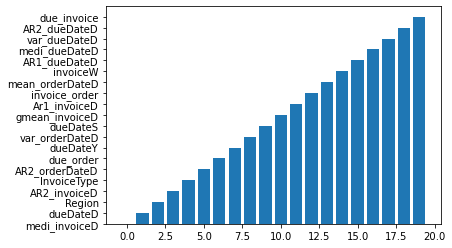

In [1098]:
#top 20 features and their feature importance
impo=model.feature_importances_
objects = [ 'Region','Amount','Disputed','InvoiceType','orderDateD','orderDateM','orderDateW','orderDateS','invoiceD','invoiceM','invoiceW','invoiceS','dueDateD','dueDateM','dueDateW','dueDateS','dueDateY','due_invoice','due_order','invoice_order','med_orderDateD','mean_orderDateD','gmean_orderDateD','var_orderDateD','std_orderDateD','cov_orderDateD','AR1_orderDateD','AR2_orderDateD','medi_invoiceD','mean_invoiceD','gmean_invoiceD','var_invoiceD','std_invoiceD','cov_invoiceD','Ar1_invoiceD','AR2_invoiceD','medi_dueDateD','mean_dueDateD','gmean_dueDateD','var_dueDateD','std_dueDateD','cov_dueDateD','AR1_dueDateD','AR2_dueDateD']

col = list(zip(objects ,impo ))
kk=np.array(col)
ee=kk[kk[:, 1].argsort()[::-1]]
NEW=(ee[:20])# top 20 features
new=NEW[NEW[:, 1].argsort()]
pyplot.bar([x for x in range(len(new[:,1]))], new[:,0])
pyplot.show()



In [ ]:
# The above graph shows that due_invoice (differnce between due date and Invoice date) has the most imformative infromation and the next one is AR2_ dueDateD which the second parameters for AR model (Autocorrelation) for due date of day data
#the third one is the variance of teh day of due date feature

In [1089]:
# convert numpy array to Pandas dataframe
df = pd.DataFrame(Y_pred, columns = ['Delay'])

In [1090]:
# replace 0 with True based on 'Delay_True' dummy variable and 1 with False one
df=df.replace(to_replace=0, value="True")
df=df.replace(to_replace=1, value="False")

In [1091]:
# save the data in CSV format with 'Delay' column

df.to_csv('result.csv',index=False)